In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# import imputer
from sklearn.impute import SimpleImputer
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor
# import XGBRegressor
from xgboost import XGBRegressor
# import random search
from sklearn.model_selection import RandomizedSearchCV


In [37]:
# load excel file
file = '/Users/rianrachmanto/pypro/project/ESP_Rate_Prediction/data/clg_datatrain_group_b_ori.xlsx'
def read_data(path):
    df = pd.read_excel(file)
    print(df.head())
    print(len(df)) 
    print(df['EQPM_TYPE'].nunique())
    print(df['WELL_NAME'].nunique())
    df.drop(['ROW_INDEX','WELL_NAME','DATE','AREA','PUMP_BRAND','EQPM_TYPE'], axis=1, inplace=True)
    print(df.head())
    X=df.drop(['BFPD'], axis=1)
    y=df['BFPD']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    return X_train, X_test, y_train, y_test,df
X_train, X_test, y_train, y_test,df = read_data(file)             

   ROW_INDEX    WELL_NAME    AREA       DATE    PUMP_BRAND     EQPM_TYPE  \
0          0  WELL_NAME_1  AREA_3 1992-04-19  PUMP_BRAND_2   EQPM_TYPE_4   
1          1  WELL_NAME_1  AREA_3 1992-05-17  PUMP_BRAND_2   EQPM_TYPE_4   
2          5  WELL_NAME_1  AREA_3 1992-12-24  PUMP_BRAND_2  EQPM_TYPE_14   
3          9  WELL_NAME_3  AREA_3 1992-04-19  PUMP_BRAND_2  EQPM_TYPE_14   
4         10  WELL_NAME_3  AREA_3 1992-05-15  PUMP_BRAND_2  EQPM_TYPE_14   

      AMPERE        VOLT  PUMP_STAGES  PUMP_SET  MOTOR_VOLTAGE  MOTOR_AMPS  \
0  54.000000  487.277771         83.0      2090          500.0        61.0   
1  52.083202  493.885468         83.0      2090          500.0        61.0   
2  41.000000  955.627930         57.0      2095         1085.0        71.0   
3  31.727261  973.583435         42.0      2224         1030.0        45.0   
4  32.000000  988.008789         42.0      2224         1030.0        45.0   

   MOTOR_HP  EQPM_STAGES  EQPM_HP         BFPD  
0      50.0           82 

         AMPERE         VOLT  PUMP_STAGES  PUMP_SET  MOTOR_VOLTAGE  \
1813  24.545454   973.727295         75.0      4260          870.0   
3542  87.000000  1223.666626         95.0      5921          945.0   
3103  41.000000   940.444458         38.0      1815          955.0   
1344  40.244270   467.112244         72.0      1659          475.0   
2825  40.250000   462.666656         53.0      3524          500.0   

      MOTOR_AMPS  MOTOR_HP  EQPM_STAGES  EQPM_HP         BFPD  
1813        45.0      60.0          169       60   705.178009  
3542       120.0     180.0           95      180  3718.998168  
3103        53.0      84.0           38       84  3236.171138  
1344        53.0      42.0           71       42   779.632344  
2825        61.0      50.0          106       50   513.648040  
            AMPERE         VOLT  PUMP_STAGES     PUMP_SET  MOTOR_VOLTAGE  \
count  3356.000000  3356.000000  3339.000000  3356.000000    3343.000000   
mean     57.834264  1043.130960    54.53878

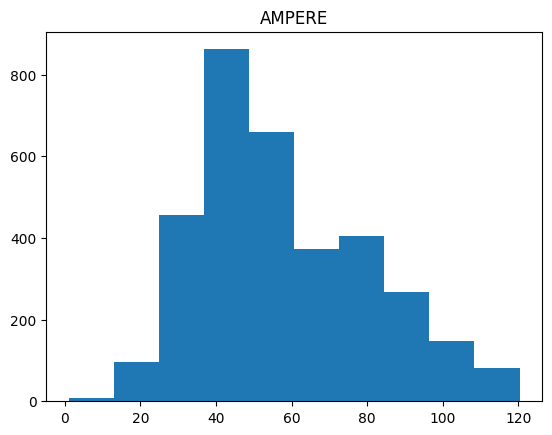

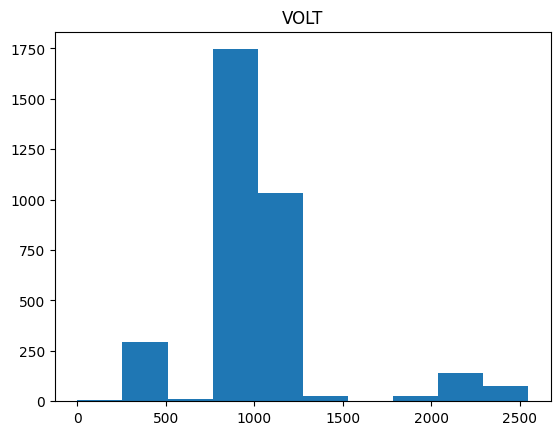

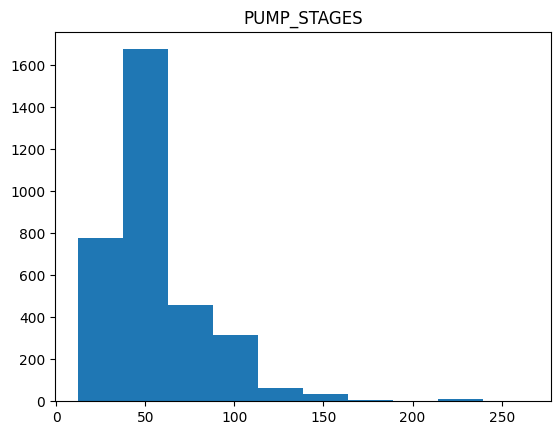

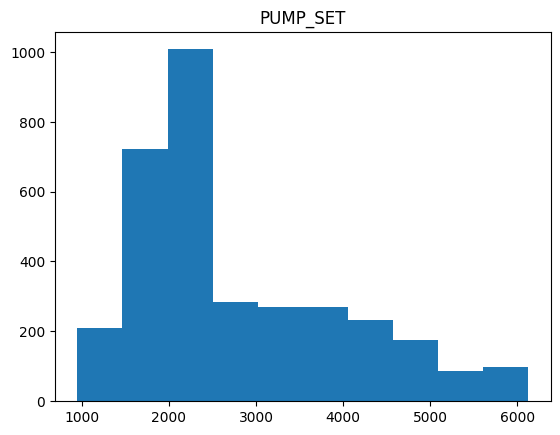

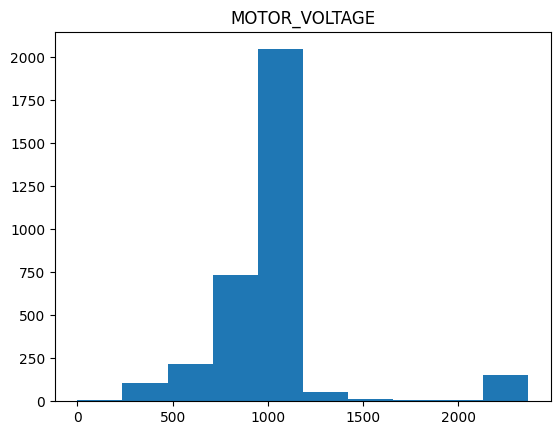

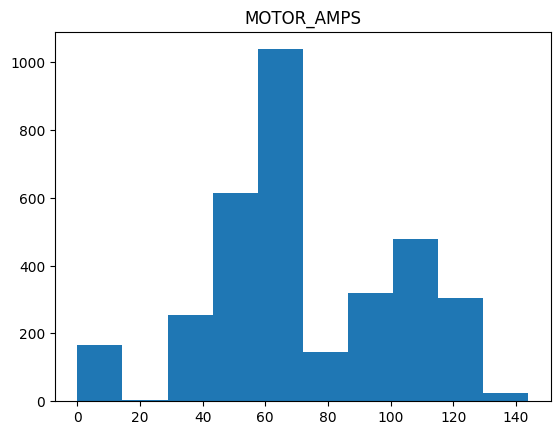

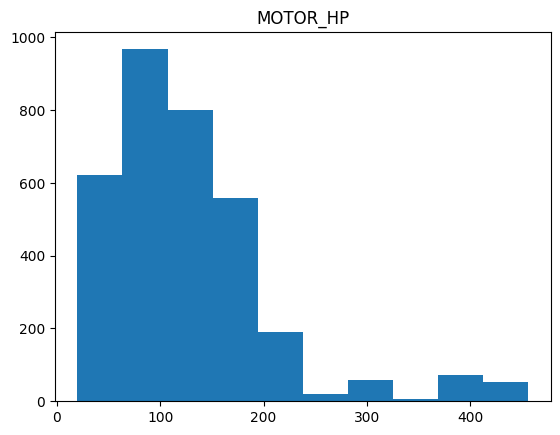

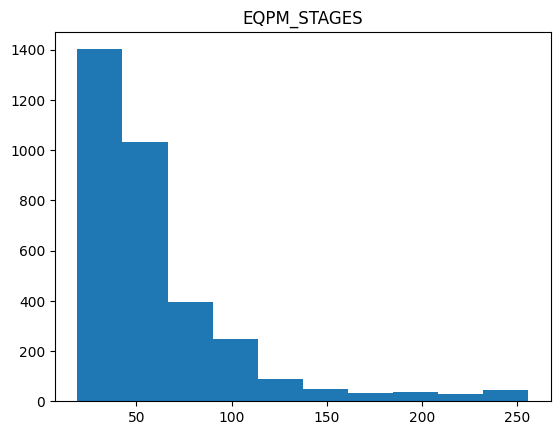

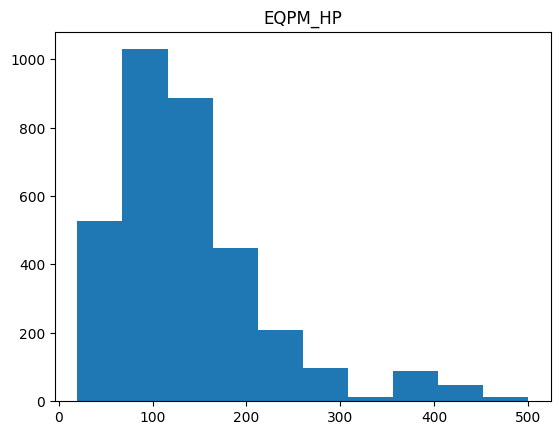

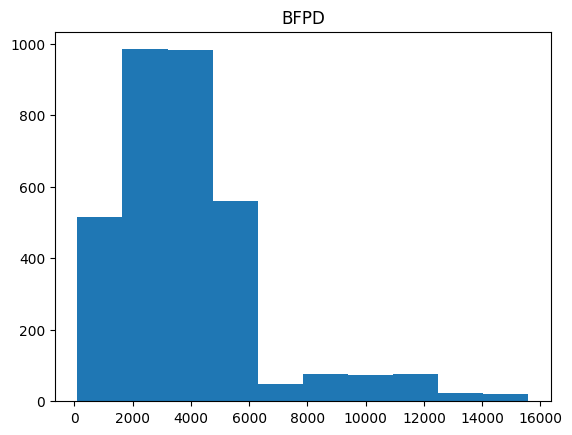

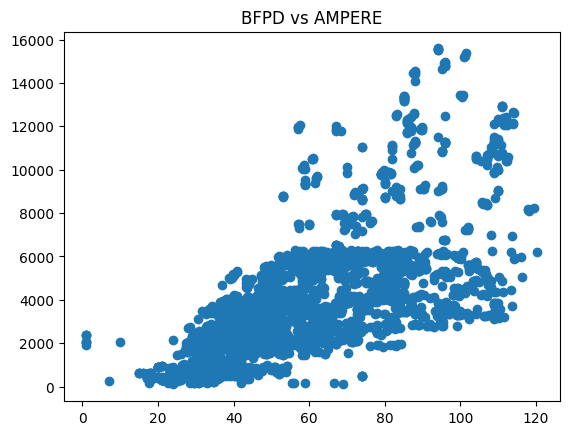

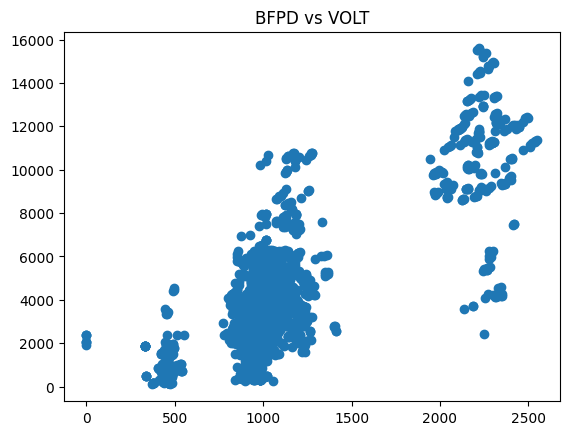

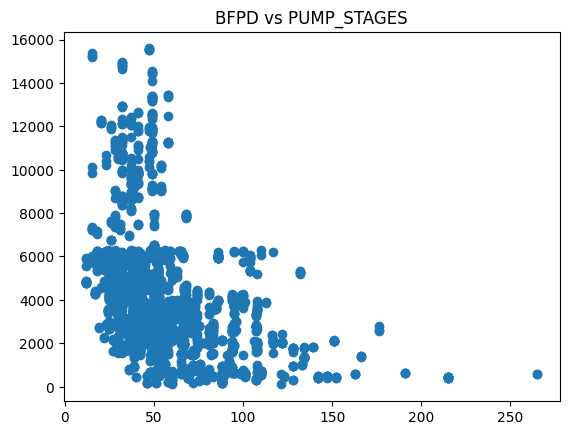

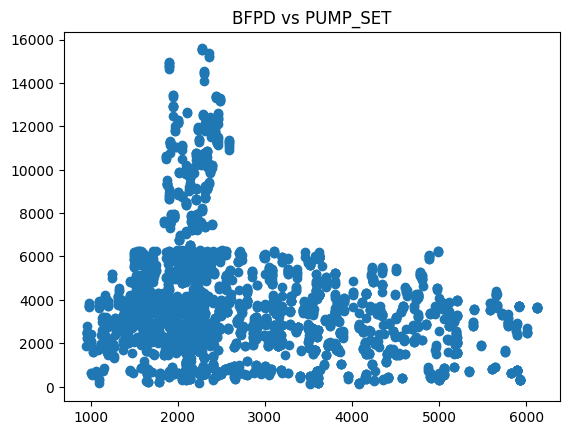

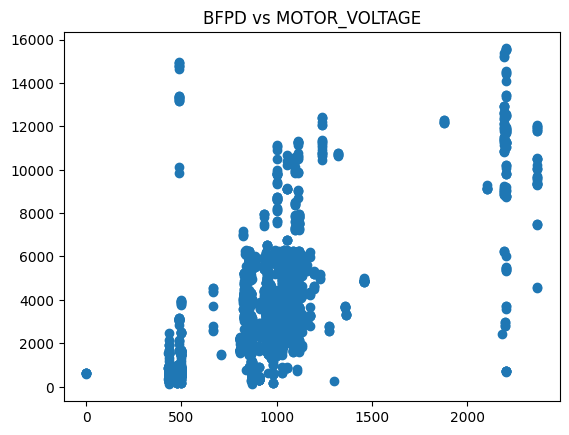

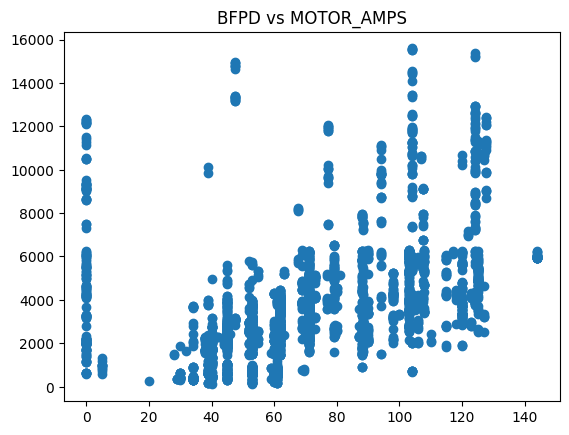

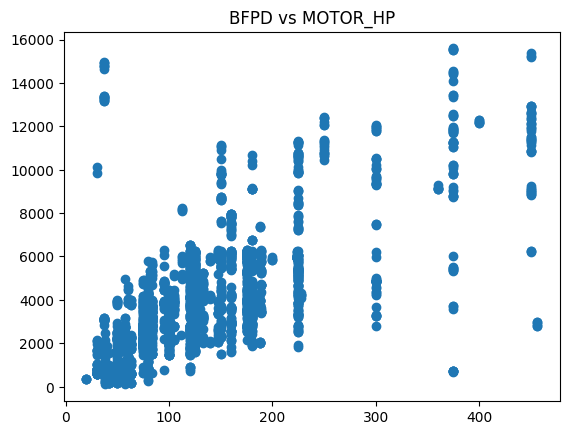

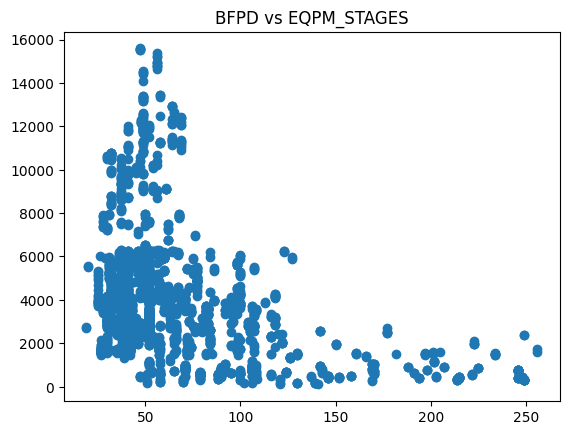

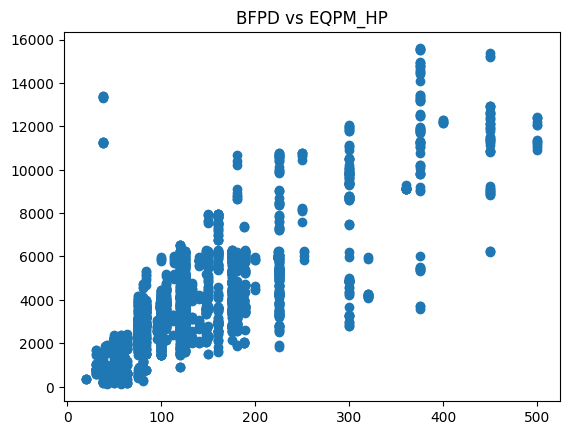

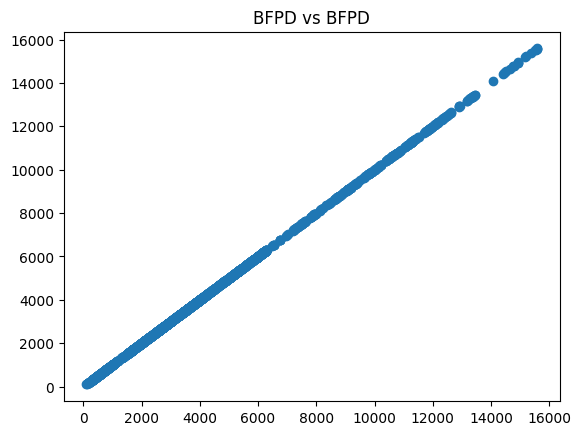

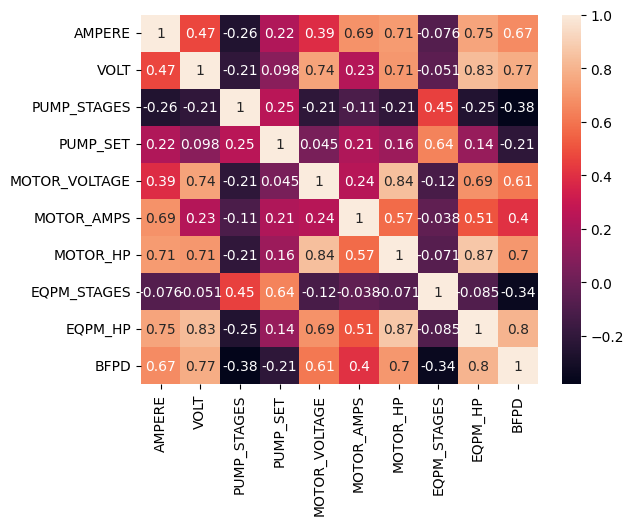

In [38]:
def eda(X_train,X_test):
    df_eda=pd.concat([X_train, y_train], axis=1)
    print(df_eda.head())
    print(df_eda.describe())
    print(df_eda.info())
    print(df_eda.isnull().sum())
    #select all numerical columns except BFPD
    num_cols = df_eda.select_dtypes(include=[np.number]).columns
    print(num_cols)
    #plot histogram for all numerical columns
    for i in num_cols:
        plt.hist(df_eda[i])
        plt.title(i)
        plt.show()
    
    #plot scatter plot of all numerical columns with BFPD
    for i in num_cols:
        plt.scatter(df_eda[i], df_eda['BFPD'])
        plt.title('BFPD vs '+i)
        plt.show()
    #plot correlation matrix
    corr = df_eda.corr()
    sns.heatmap(corr, annot=True)
    plt.show()
    return df_eda
df_eda = eda(X_train,X_test)

In [39]:
class dataprocess():
    def __init__(self,X_train,X_test):
        self.X_train = X_train
        self.X_test = X_test
    def process_train(self):
        #fill missing values with imputing
        imputer = SimpleImputer(strategy='mean')
        imputer.fit(self.X_train)
        self.X_train = imputer.transform(self.X_train)
        return self.X_train
    def process_test(self):
        #fill missing values with imputing
        imputer = SimpleImputer(strategy='mean')
        imputer.fit(self.X_test)
        self.X_test = imputer.transform(self.X_test)
        return self.X_test
    

In [40]:
df=dataprocess(X_train,X_test)
X_train = df.process_train()
X_test = df.process_test()


In [41]:
#create simple baseline model to be comparated with random forest and xgboost

class baseline():
    def __init__(self,X_train,X_test,y_train,y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    def model(self):
        #create baseline model
        y_pred = np.mean(self.y_train)
        #calculate baseline model
        baseline_model = np.mean(np.abs(y_pred - self.y_test))
        print('Baseline model:',baseline_model)
        return baseline_model

In [42]:
based_model = baseline(X_train,X_test,y_train,y_test)
based_model.model()

Baseline model: 1919.605397115155


1919.605397115155

In [43]:
def random_forest(X_train,X_test,y_train,y_test):
    #create random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    #calculate random forest model
    rf_model = np.mean(np.abs(y_pred - y_test))
    print('Random Forest model:',rf_model)
    return rf_model

In [44]:
rf_model = random_forest(X_train,X_test,y_train,y_test)

Random Forest model: 118.41465852029685


In [45]:
def xgboost(X_train,X_test,y_train,y_test):
    #create xgboost model
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    #calculate xgboost model
    xgb_model = np.mean(np.abs(y_pred - y_test))
    print('XGBoost model:',xgb_model)
    return xgb_model

In [46]:
xgb_model = xgboost(X_train,X_test,y_train,y_test)

XGBoost model: 119.85152979195544


In [47]:
#create dataframe to compare all models
models = pd.DataFrame({
    'Model': ['Baseline', 'Random Forest', 'XGBoost'],
    'Score': [based_model.model(), rf_model, xgb_model]})
print(models)

Baseline model: 1919.605397115155
           Model        Score
0       Baseline  1919.605397
1  Random Forest   118.414659
2        XGBoost   119.851530


In [48]:
#train random forest model with random search
def random_forest_rs(X_train,X_test,y_train,y_test):
    #create random forest model
    rf = RandomForestRegressor()
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    y_pred = rf_random.predict(X_test)
    #calculate random forest model
    rf_model_rs = np.mean(np.abs(y_pred - y_test))
    print('Random Forest model with Random Search:',rf_model_rs)
    return rf_model_rs

In [49]:
rf_model_rs = random_forest_rs(X_train,X_test,y_train,y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   2.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   7.5s
[CV] END bootstrap=False, max_depth=10, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
87 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Random Forest model with Random Search: 76.605525547234
